In [1]:
!pip install --upgrade pip
!pip install requests
!pip install pandas
!pip install nltk
!pip install contractions
!pip install torch torchvision torchaudio
!pip install transformers
!pip install scikit-learn
!pip install tqdm
!pip install matplotlib
!pip install wordcloud
!pip install yfinance

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl (199 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]4/5 [requests]
  Using cached panda

In [2]:
import requests
import json
import pandas as pd
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from datetime import datetime, timedelta
from tqdm import tqdm
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import yfinance as yf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ✅ NLTK 다운로드
nltk.download('punkt')  
nltk.download('stopwords') 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

/Users/leejunho/coding/3-1/datamining/test/venv_datamining/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/leejunho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leejunho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leejunho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def is_valid_ticker(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return 'shortName' in info
    except Exception as e:
        return False

In [4]:
date = datetime.now()
date = date.strftime("%Y-%m-%d")

DEFAULT_TITLE = "4 Key Takeaways From Google Parent Alphabet's Earnings Call"
DEFAULT_SUMMARY = (
    "Alphabet, Google's parent company, reported exceptional first-quarter results, "
    "surpassing analysts' expectations. The company is focused on expanding artificial "
    "intelligence capabilities in its products, while also announcing its first dividend "
    "for shareholders. AI played a crucial role in the earnings call, with CEO Sundar Pichai "
    "emphasizing Google's AI infrastructure and plans to integrate AI into its core search product. "
    "The company's extensive customer base and history of AI investments position it well for "
    "future AI innovation. Alphabet is committed to maintaining healthy margins while investing in AI, "
    "and sees clear pathways to monetizing AI through advertising, Google Cloud, and subscriptions. "
    "The introduction of a dividend and a new stock buyback program have further strengthened "
    "Alphabet's position, leading to a significant increase in its stock price."
)
DEFAULT_TICKER = "AAPL"

# 초기화
news_title = None
news_summary = None
nyse = None

# 하나의 루프로 입력 받기
while True:
    if news_title is None:
        t = input("뉴스 제목을 입력하세요: ").strip()
        if t == "":
            if input("뉴스 제목이 비어있습니다. 기본값을 사용하시겠습니까? (y/n): ").lower().strip() == 'y':
                news_title = DEFAULT_TITLE
        else:
            news_title = t

    if news_summary is None:
        s = input("뉴스 요약을 입력하세요: ").strip()
        if s == "":
            if input("뉴스 요약이 비어있습니다. 기본값을 사용하시겠습니까? (y/n): ").lower().strip() == 'y':
                news_summary = DEFAULT_SUMMARY
        else:
            news_summary = s

    if nyse is None:
        n = input("NYSE 티커를 입력하세요 (예: AAPL): ").strip().upper()
        if n == "":
            if input("NYSE 티커가 비어있습니다. 기본값(AAPL)을 사용하시겠습니까? (y/n): ").lower().strip() == 'y':
                nyse = DEFAULT_TICKER
        elif is_valid_ticker(n):
            nyse = n
        else:
            print(f"'{n}'는 유효한 NYSE 티커가 아닙니다. 다시 입력해주세요.")

    # 세 개가 모두 유효하면 루프 탈출
    if news_title and news_summary and nyse:
        break

# 뉴스 텍스트 구성
news_text = news_title + " " + news_summary


In [5]:
def preproces_text(text):
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w{1,3}\b', '', text)
    return text

In [6]:
end_date = datetime.strptime(date, "%Y-%m-%d")
months_to_collect = 24
step_days = 30
deepsearch_api_key = "cffaa97f7c2f4ad0bd501ce7cd00b7e1"
polygon_api_key = "7A2qEj2N1XlxkYJogRqKFtkBWUkr32UQ"

df_all = pd.DataFrame()

for _ in range(months_to_collect):
    start_date = end_date - timedelta(days=step_days)
    start = start_date.strftime('%Y-%m-%d')
    end = end_date.strftime('%Y-%m-%d')

    for i in range(1, 46):
        url_news = f'https://api-v2.deepsearch.com/v1/global-articles?symbols=NYSE:{nyse}&page={i}&page_size=100&date_from={start}&date_to={end}&api_key={deepsearch_api_key}'
        data_news = requests.get(url_news).json()
        if(data_news["data"] == []):
            break
        temp_df = pd.DataFrame([{
            "Date": item["published_at"],
            "title": item["title"],
            "summary": item["summary"]
        } for item in data_news["data"]])
        df_news = pd.concat([df_news, temp_df]) if i > 1 else temp_df

    df_news['Date'] = pd.to_datetime(df_news['Date']).dt.tz_convert('America/New_York')
    df_news['Date'] = df_news['Date'].dt.strftime('%Y-%m-%d %H:%M:00')

    url_stock = f"https://api.polygon.io/v2/aggs/ticker/{nyse}/range/1/minute/{start}/{end}?limit=50000&apiKey={polygon_api_key}"
    data_stock = requests.get(url_stock).json()
    if "results" in data_stock:
        df_price = pd.DataFrame(data_stock["results"])
        df_price["t"] = pd.to_datetime(df_price["t"], unit="ms")
        df_price.rename(columns={"t": "Time", "o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
        df_price["Change"] = df_price["Close"] - df_price["Open"]
        df_price = df_price[["Time", "Open", "High", "Low", "Close", "Volume", "Change"]]
        df_news['Date'] = pd.to_datetime(df_news['Date'])
        df_merged = pd.merge(df_price, df_news, left_on="Time", right_on="Date", how="left")
        df_merged = df_merged.drop(columns=["Date"])
        df_merged = df_merged.dropna(subset=["title", "summary"])
        df_all = pd.concat([df_all, df_merged], ignore_index=True)
        print(f"✅Fetched stock data for {start} to {end}")
    else :
        print(f"❌ Stock API Error for {start} ~ {end}: {data_stock.get('error', 'Unknown error')}")
    end_date = start_date

    if start_date < datetime.now() - timedelta(days=400):
        break

df_all

✅Fetched stock data for 2025-05-13 to 2025-06-12
✅Fetched stock data for 2025-04-13 to 2025-05-13
✅Fetched stock data for 2025-03-14 to 2025-04-13
✅Fetched stock data for 2025-02-12 to 2025-03-14
✅Fetched stock data for 2025-01-13 to 2025-02-12
✅Fetched stock data for 2024-12-14 to 2025-01-13
✅Fetched stock data for 2024-11-14 to 2024-12-14
✅Fetched stock data for 2024-10-15 to 2024-11-14
✅Fetched stock data for 2024-09-15 to 2024-10-15
✅Fetched stock data for 2024-08-16 to 2024-09-15
✅Fetched stock data for 2024-07-17 to 2024-08-16
✅Fetched stock data for 2024-06-17 to 2024-07-17
✅Fetched stock data for 2024-05-18 to 2024-06-17
✅Fetched stock data for 2024-04-18 to 2024-05-18


,Time,Open,High,Low,Close,Volume,Change,title,summary
0,2025-05-13 08:00:00,122.1500,122.410,122.130,122.2300,18716.0,0.0800,What Lessons Can Investors Learn From Cathie W...,"Cathie Wood, renowned for her aggressive inves..."
1,2025-05-13 08:51:00,121.7300,121.820,121.730,121.8200,11624.0,0.0900,Nvidia poised to rejoin $3 trillion club after...,Nvidia is poised to reenter the $3 trillion ma...
2,2025-05-13 08:58:00,121.8200,121.820,121.820,121.8200,908.0,0.0000,Analyst Says ‘Nobody’ Can Catch Up With NVIDIA...,Markets reacted positively to a new US-China t...
3,2025-05-13 10:01:00,122.3300,122.350,122.240,122.3000,10842.0,-0.0300,If You Invested $15K in These 3 Stocks 15 Year...,"Investing in speculative stocks can be risky, ..."
4,2025-05-13 10:15:00,122.8700,122.870,122.800,122.8000,7439.0,-0.0700,HUMAIN and NVIDIA Announce Strategic Partnersh...,"HUMAIN, a subsidiary of Saudi Arabia’s Public ..."
...,...,...,...,...,...,...,...,...,...
10293,2024-05-16 16:13:00,95.0272,95.101,95.022,95.0670,730430.0,0.0398,What You Need To Know Ahead of Nvidia's Earnin...,Nvidia is scheduled to announce its fiscal Q1 ...
10294,2024-05-16 20:00:00,94.3590,94.412,94.344,94.3600,2616190.0,0.0010,Globant S.A. (GLOB) Q1 2024 Earnings Call Tran...,Globant's first-quarter 2024 earnings call rev...
10295,2024-05-17 11:17:00,94.1680,94.168,94.168,94.1680,4570.0,0.0000,Fabrinet: Sustained Demand For AI Networking B...,"Fabrinet's stock surged over 157% last year, o..."
10296,2024-05-17 11:54:00,94.0530,94.053,94.050,94.0500,20870.0,-0.0030,Apple: Here's My Price Target And WWDC Strategy,The article discusses the recent performance o...


In [7]:
df_all['upndown'] = df_all['Change'].apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'same'))
df_all = df_all[["Time", "Open", "High", "Low", "Close", "Volume", "Change", 'upndown', "title", "summary"]]

df_all["title"] = df_all["title"].apply(preproces_text)
df_all["summary"] = df_all["summary"].apply(preproces_text)
df_all["text"] = df_all["title"] + " " + df_all["summary"]

df_up = df_all[df_all['upndown'] == 'up']
df_down = df_all[df_all['upndown'] == 'down']
df_same = df_all[df_all['upndown'] == 'same']

count_up = len(df_up)
count_down = len(df_down)
count_same = len(df_same)
min_count = min(count_up, count_down, count_same)

df_up = df_up.sample(n=min_count, random_state=42)
df_down = df_down.sample(n=min_count, random_state=42)
df_same = df_same.sample(n=min_count, random_state=42)

df_balanced = pd.concat([df_up, df_down, df_same], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced['Time'] = pd.to_datetime(df_balanced['Time'])
df_balanced = df_balanced.sort_values(by='Time').reset_index(drop=True)

df_balanced

,Time,Open,High,Low,Close,Volume,Change,upndown,title,summary,text
0,2024-04-18 11:59:00,85.275,85.300,85.275,85.3000,25610.0,0.0250,up,yous tech ceos give india modi boost ahead e...,indias prime minister narendra modi built st...,yous tech ceos give india modi boost ahead e...
1,2024-04-19 22:38:00,76.214,76.214,76.214,76.2140,12080.0,0.0000,same,return midcaps,spdr midcap trust nysearcamdy managed st...,return midcaps spdr midcap trust nys...
2,2024-04-19 22:38:00,76.214,76.214,76.214,76.2140,12080.0,0.0000,same,return midcaps,spdr midcap trust nysearcamdy exchangetr...,return midcaps spdr midcap trust nys...
3,2024-04-22 08:15:00,77.200,77.250,77.200,77.2000,35100.0,0.0000,same,here mondays biggest analyst calls apple nvid...,wall street analysts issued significant calls ...,here mondays biggest analyst calls apple nvid...
4,2024-04-23 09:43:00,80.600,80.600,80.600,80.6000,6440.0,0.0000,same,earnings this week will dominated tech what...,tech earnings expected provide muchneeded b...,earnings this week will dominated tech what...
...,...,...,...,...,...,...,...,...,...,...,...
1540,2025-06-10 16:08:00,142.945,142.950,142.870,142.9099,120355.0,-0.0351,down,best large stocks watch today june,tesla invesco nvidia apple palantir technolo...,best large stocks watch today june tesla in...
1541,2025-06-10 20:41:00,143.950,144.000,143.910,143.9700,24684.0,0.0200,up,mark stevens sells shares nvidia nasdaqnvd...,nvidia director mark stevens sold shares ...,mark stevens sells shares nvidia nasdaqnvd...
1542,2025-06-11 08:25:00,143.660,143.660,143.660,143.6600,666.0,0.0000,same,here wednesdays biggest analyst calls nvidia ...,wednesday wall street flurry notable stock...,here wednesdays biggest analyst calls nvidia ...
1543,2025-06-11 09:13:00,143.860,143.860,143.800,143.8300,6714.0,-0.0300,down,quantum computing stocks surge nvidia huang ...,shares quantum computing companies surged pr...,quantum computing stocks surge nvidia huang ...


In [8]:
le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['upndown'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'].tolist(),
    df_balanced['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [9]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_loader = DataLoader(NewsDataset(train_texts, train_labels, tokenizer), batch_size=16, shuffle=True)
val_loader = DataLoader(NewsDataset(val_texts, val_labels, tokenizer), batch_size=16)

In [11]:
device_bert = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device_bert)
optimizer_bert = torch.optim.AdamW(model_bert.parameters(), lr=2e-5)

for epoch in range(3):
    model_bert.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device_bert)
        attention_mask = batch['attention_mask'].to(device_bert)
        labels = batch['labels'].to(device_bert)
        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        optimizer_bert.zero_grad()
        loss.backward()
        optimizer_bert.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

model_bert.save_pretrained("bert_news_test_model")
tokenizer.save_pretrained("bert_news_test_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 78/78 [03:50<00:00,  2.96s/it]


Epoch 1 Loss: 86.4405


Epoch 2: 100%|██████████| 78/78 [03:56<00:00,  3.04s/it]


Epoch 2 Loss: 85.8622


Epoch 3: 100%|██████████| 78/78 [05:04<00:00,  3.91s/it]


Epoch 3 Loss: 84.7005


('bert_news_test_model/tokenizer_config.json',
 'bert_news_test_model/special_tokens_map.json',
 'bert_news_test_model/vocab.txt',
 'bert_news_test_model/added_tokens.json')

In [12]:
start_dt =datetime.strptime(date, "%Y-%m-%d") - timedelta(days=400)
end_dt = datetime.strptime(date, "%Y-%m-%d")

df_all_stock = pd.DataFrame()

while start_dt < end_dt:
    to_dt = min(start_dt + timedelta(days=10), end_dt)
    start = start_dt.strftime("%Y-%m-%d")
    end = to_dt.strftime("%Y-%m-%d")

    url = f"https://api.polygon.io/v2/aggs/ticker/{nyse}/range/1/minute/{start}/{end}?limit=50000&apiKey={polygon_api_key}"
    response = requests.get(url)
    data = response.json()

    if "results" in data:
        df_price = pd.DataFrame(data["results"])
        df_price["t"] = pd.to_datetime(df_price["t"], unit="ms")
        df_price.rename(columns={"t": "Time", "o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
        df_price = df_price[["Time", "Open", "High", "Low", "Close", "Volume"]]
        df_all_stock = pd.concat([df_all_stock, df_price], ignore_index=True)
        df_all_stock["Change"] = df_all_stock["Close"] - df_all_stock["Open"]
        df_all_stock["upndown"] = df_all_stock["Change"].apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'same'))
    else:
        print(f"❌ Stock API Error for {start} ~ {end}: {data.get('error', 'Unknown error')}")

    start_dt = to_dt + timedelta(days=1)
    print(f"✅ 수집 완료: {start} ~ {end}")
    time.sleep(10)

✅ 수집 완료: 2024-05-08 ~ 2024-05-18
✅ 수집 완료: 2024-05-19 ~ 2024-05-29
✅ 수집 완료: 2024-05-30 ~ 2024-06-09
✅ 수집 완료: 2024-06-10 ~ 2024-06-20
✅ 수집 완료: 2024-06-21 ~ 2024-07-01
✅ 수집 완료: 2024-07-02 ~ 2024-07-12
❌ Stock API Error for 2024-07-13 ~ 2024-07-23: You've exceeded the maximum requests per minute, please wait or upgrade your subscription to continue. https://polygon.io/pricing
✅ 수집 완료: 2024-07-13 ~ 2024-07-23
✅ 수집 완료: 2024-07-24 ~ 2024-08-03
✅ 수집 완료: 2024-08-04 ~ 2024-08-14
✅ 수집 완료: 2024-08-15 ~ 2024-08-25
✅ 수집 완료: 2024-08-26 ~ 2024-09-05
✅ 수집 완료: 2024-09-06 ~ 2024-09-16
✅ 수집 완료: 2024-09-17 ~ 2024-09-27
✅ 수집 완료: 2024-09-28 ~ 2024-10-08
✅ 수집 완료: 2024-10-09 ~ 2024-10-19
✅ 수집 완료: 2024-10-20 ~ 2024-10-30
✅ 수집 완료: 2024-10-31 ~ 2024-11-10
✅ 수집 완료: 2024-11-11 ~ 2024-11-21
✅ 수집 완료: 2024-11-22 ~ 2024-12-02
✅ 수집 완료: 2024-12-03 ~ 2024-12-13
✅ 수집 완료: 2024-12-14 ~ 2024-12-24
✅ 수집 완료: 2024-12-25 ~ 2025-01-04
✅ 수집 완료: 2025-01-05 ~ 2025-01-15
✅ 수집 완료: 2025-01-16 ~ 2025-01-26
✅ 수집 완료: 2025-01-27 ~ 2025-02-0

In [13]:
df = df_balanced.copy()

scaler = MinMaxScaler()
df["Close_scaled"] = scaler.fit_transform(df[["Close"]])

SEQ_LEN = 20

class StockRegressionDataset(Dataset):
    def __init__(self, df, seq_len):
        self.x = []
        self.y = []
        closes = df["Close_scaled"].values
        for i in range(len(closes) - seq_len):
            self.x.append(closes[i:i+seq_len])
            self.y.append(closes[i+seq_len])
        self.x = np.array(self.x)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx].astype(np.float32)).unsqueeze(-1), torch.tensor(self.y[idx], dtype=torch.float32)


dataset = StockRegressionDataset(df, SEQ_LEN)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device_LSTM = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_LSTM = LSTMRegressor().to(device_LSTM)

criterion_LSTM = nn.MSELoss()
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=0.001)

for epoch in range(5):
    model_LSTM.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device_LSTM)
        y_batch = y_batch.to(device_LSTM).unsqueeze(-1)
        optimizer_LSTM.zero_grad()
        outputs_LSTM = model_LSTM(x_batch)
        loss = criterion_LSTM(outputs_LSTM, y_batch)
        loss.backward()
        optimizer_LSTM.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

torch.save(model_LSTM.state_dict(), "lstm_stock_regressor.pth")

Epoch 1, Loss: 3.2973
Epoch 2, Loss: 0.6110
Epoch 3, Loss: 0.1811
Epoch 4, Loss: 0.1394
Epoch 5, Loss: 0.1206


In [19]:
tokenizer = BertTokenizer.from_pretrained("bert_news_test_model")
bert_model = BertForSequenceClassification.from_pretrained("bert_news_test_model")
bert_model.eval()

encoding = tokenizer(news_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
with torch.no_grad():
    bert_output = bert_model(**encoding)
    bert_probs = F.softmax(bert_output.logits, dim=1).cpu().numpy()[0]  # [up, down, same]

# LSTM 회귀 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# 스케일링
scaler = MinMaxScaler()
df_all_stock["Close_scaled"] = scaler.fit_transform(df_all_stock[["Close"]])
last_seq = torch.FloatTensor(df_all_stock["Close_scaled"].values[-20:]).unsqueeze(0).unsqueeze(-1)

# LSTM 회귀 모델 로드 및 예측
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMRegressor().to(device)
lstm_model.load_state_dict(torch.load("lstm_stock_regressor.pth", map_location=device))
lstm_model.eval()

with torch.no_grad():
    last_seq = last_seq.to(device)
    predicted_scaled_price = lstm_model(last_seq).cpu().numpy()[0][0]
    predicted_price = scaler.inverse_transform([[predicted_scaled_price]])[0][0]

# 예측된 종가와 이전 종가 비교하여 up/down/same 분류
previous_close = df_all_stock["Close"].values[-1]
change = predicted_price - previous_close

if change > 0.1:
    lstm_direction_probs = [1.0, 0.0, 0.0]  # up
elif change < -0.1:
    lstm_direction_probs = [0.0, 1.0, 0.0]  # down
else:
    lstm_direction_probs = [0.0, 0.0, 1.0]  # same

# BERT 확률과 평균
avg_probs = (bert_probs + np.array(lstm_direction_probs)) / 2
labels = ['up', 'down', 'same']
final_prediction = labels[np.argmax(avg_probs)]

# 출력
print("📈 예측된 종가:", f"{predicted_price:.2f}")
print("📉 직전 종가:", f"{previous_close:.2f}")
print("↕️ 변화량:", f"{change:.2f}")
print("\n📊 평균 확률 (BERT + LSTM):")
for label, prob in zip(labels, avg_probs):
    print(f" - {label}: {prob * 100:.2f}%")

print(f"\n✅ 최종 예측 결과: {final_prediction.upper()}")


📈 예측된 종가: 141.30
📉 직전 종가: 142.21
↕️ 변화량: -0.91

📊 평균 확률 (BERT + LSTM):
 - up: 21.19%
 - down: 59.72%
 - same: 19.09%

✅ 최종 예측 결과: DOWN


In [15]:
start = '2025-05-01'
end = '2025-05-20'

for i in range (1, 30):
    if(i == 1):
        url = 'https://api-v2.deepsearch.com/v1/global-articles?symbols=NYSE:'+nyse+'&page='+str(i)+'&page_size=100&date_from='+start+'&date_to='+end+'&api_key=cffaa97f7c2f4ad0bd501ce7cd00b7e1'
        data = requests.get(url).json()
        title_summary_list = [(item["title"], item["summary"], item["published_at"]) for item in data["data"]]
        df_news_test = pd.DataFrame([
            {"Date": published_at, "title": title, "summary": summary}
            for title, summary, published_at in title_summary_list
        ])
    else:
        url = 'https://api-v2.deepsearch.com/v1/global-articles?symbols=NYSE:'+nyse+'&page='+str(i)+'&page_size=100&date_from='+start+'&date_to='+end+'&api_key=cffaa97f7c2f4ad0bd501ce7cd00b7e1'
        data = requests.get(url).json()
        title_summary_list = [(item["title"], item["summary"], item["published_at"]) for item in data["data"]]
        df_news_test_temp = pd.DataFrame([
            {"Date": published_at, "title": title, "summary": summary}
            for title, summary, published_at in title_summary_list
        ])
        df_news_test = pd.concat([df_news_test, df_news_test_temp], ignore_index=True)

df_news_test['Date'] = pd.to_datetime(df_news_test['Date']).dt.tz_convert('America/New_York')
df_news_test['Date'] = df_news_test['Date'].dt.strftime('%Y-%m-%d %H:%M:00')


api_key = "7A2qEj2N1XlxkYJogRqKFtkBWUkr32UQ"
url = f"https://api.polygon.io/v2/aggs/ticker/{nyse}/range/1/minute/{start}/{end}?limit=50000&apiKey=7A2qEj2N1XlxkYJogRqKFtkBWUkr32UQ"

response = requests.get(url)
data = response.json()
if "results" in data:
    df_poly = pd.DataFrame(data["results"])
    df_poly["t"] = pd.to_datetime(df_poly["t"], unit="ms")
    df_poly.rename(columns={"t":"Time","o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    df_poly["Change"] = df_poly["Close"] - df_poly["Open"]
    df_poly = df_poly[["Time","Open", "High", "Low", "Close", "Volume", "Change"]]
    df_news_test['Date'] = pd.to_datetime(df_news_test['Date'])
    df_poly = pd.merge(df_poly, df_news_test, left_on="Time", right_on="Date", how="left")
    df_poly = df_poly.drop(columns=["Date"])
    #title과 summary가 NaN인 행을 삭제 한다.
    df_poly = df_poly.dropna(subset=["title", "summary"])
else:
    print("Error: ", data["error"])

# df_upndown이라는 새로운 df를 만들어 해당 date에 close - open을 하여 이 값이 > 0 이면 up, < 0 이면 down, == 0 이면 same으로 df에 추가

df_upndown_test = df_poly.copy()
df_upndown_test['upndown'] = df_upndown_test['Change'].apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'same'))
df_upndown_test = df_upndown_test[["Time","Open", "High", "Low", "Close", "Volume", "Change",'upndown',"title", "summary"]]
df_upndown_test.to_csv("AAPL_2025_test.csv", index=False)

df = df_upndown_test.copy()
df = df.dropna(subset=['title', 'summary'])
df["text"] = df["title"] + " " + df["summary"]

# 라벨 매핑
label_map = {'up': 0, 'down': 1, 'same': 2}
df["label"] = df["upndown"].map(label_map)

# ✅ BERT 예측 함수
bert_model = BertForSequenceClassification.from_pretrained("bert_news_test_model")
bert_tokenizer = BertTokenizer.from_pretrained("bert_news_test_model")
bert_model.eval()

def predict_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return pred, probs.numpy()[0]

# ✅ LSTM 회귀용 전처리
SEQ_LEN = 20
scaler = MinMaxScaler()
df["Close_scaled"] = scaler.fit_transform(df[["Close"]])

class LSTMDataset(Dataset):
    def __init__(self, df, seq_len=SEQ_LEN):
        self.x = []
        self.y = []
        close_scaled = df["Close_scaled"].values
        closes = df["Close"].values
        for i in range(len(df) - seq_len):
            self.x.append(close_scaled[i:i+seq_len])
            self.y.append(closes[i+seq_len])
        self.x = np.array(self.x)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]).unsqueeze(-1), torch.tensor(self.y[idx], dtype=torch.float)

lstm_dataset = LSTMDataset(df)
lstm_loader = DataLoader(lstm_dataset, batch_size=1, shuffle=False)

# ✅ 회귀용 LSTM 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMRegressor().to(device)
lstm_model.load_state_dict(torch.load("lstm_stock_regressor.pth", map_location=device))
lstm_model.eval()

# ✅ 예측 및 평가
avg_preds, labels = [], []

for i in range(len(lstm_dataset)):
    # LSTM 회귀 예측 → 방향 분류
    x_seq, y_true_price = lstm_dataset[i]
    x_seq = x_seq.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_price = lstm_model(x_seq).item()
    current_price = df.iloc[i + SEQ_LEN]["Close"]
    diff = pred_price - current_price
    lstm_label = 0 if diff > 0.1 else (1 if diff < -0.1 else 2)

    # BERT 분류
    text = df.iloc[i + SEQ_LEN]["text"]
    bert_pred, bert_prob = predict_bert(text)

    # 평균 확률
    lstm_prob = [0.0, 0.0, 0.0]
    lstm_prob[lstm_label] = 1.0
    avg_prob = (np.array(lstm_prob) + np.array(bert_prob)) / 2
    avg_pred = np.argmax(avg_prob)

    # 저장
    labels.append(df.iloc[i + SEQ_LEN]["label"])
    avg_preds.append(avg_pred)

total = len(labels)
correct = sum([int(p == l) for p, l in zip(avg_preds, labels)])
print(f"정확도: {correct}/{total} ({correct / total:.2%})")

정확도: 238/492 (48.37%)


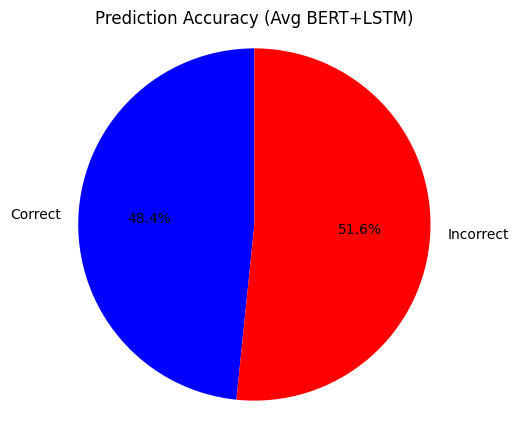

In [16]:
import matplotlib.pyplot as plt

# 맞은 개수와 틀린 개수 계산
total = len(labels)
correct = sum([int(p == l) for p, l in zip(avg_preds, labels)])
incorrect = total - correct

# 파이차트 데이터 설정
sizes = [correct, incorrect]
labels_pie = ['Correct', 'Incorrect']
colors = ['blue', 'red']

# 파이차트 그리기
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels_pie, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Prediction Accuracy (Avg BERT+LSTM)")
plt.axis('equal')  # 원형 비율 유지
plt.show()


BERT + LSTM Classification Report:
              precision    recall  f1-score   support

          up       0.00      0.00      0.00       229
        down       0.48      1.00      0.65       238
        same       0.00      0.00      0.00        25

    accuracy                           0.48       492
   macro avg       0.16      0.33      0.22       492
weighted avg       0.23      0.48      0.32       492



/Users/leejunho/coding/3-1/datamining/test/venv_datamining/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leejunho/coding/3-1/datamining/test/venv_datamining/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leejunho/coding/3-1/datamining/test/venv_datamining/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

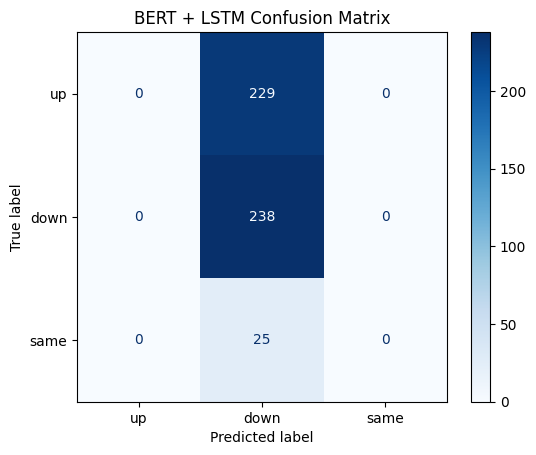

In [17]:
# 클래스 라벨
target_names = ['up', 'down', 'same']

# 1. 정확도 + classification_report
def full_report(preds, labels, name):
    print(f"\n{name} Classification Report:")
    print(classification_report(labels, preds, target_names=target_names))

# 2. 혼동 행렬 시각화
def show_conf_matrix(preds, labels, name):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

full_report(avg_preds, labels, "BERT + LSTM")
show_conf_matrix(avg_preds, labels, "BERT + LSTM")


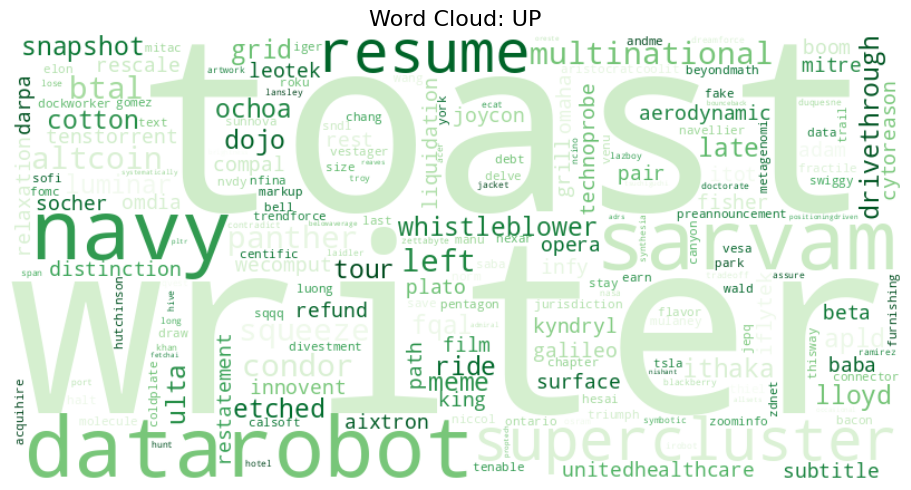

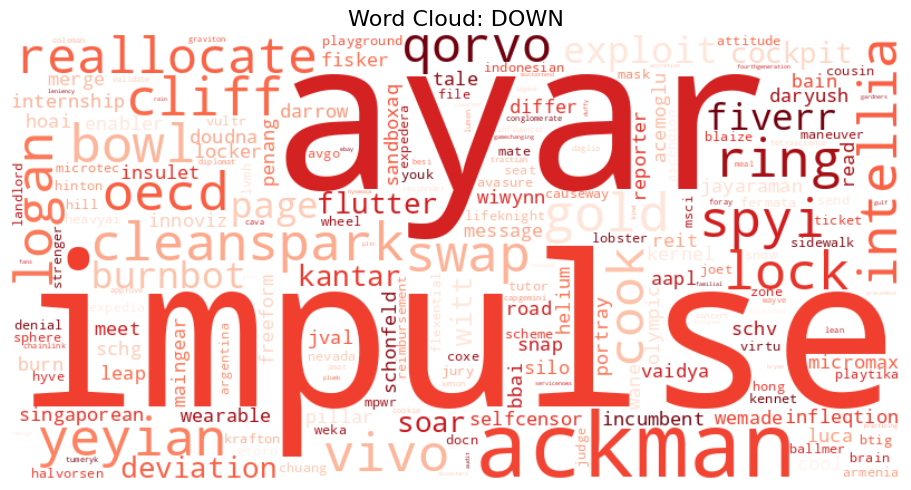

In [18]:
# CSV 데이터 로드 및 전처리
df = df_all.copy()

# 텍스트 전처리 (소문자 + 단어 추출)
words_up = set(re.findall(r'\b\w+\b', ' '.join(df[df['upndown'] == 'up']['summary']).lower()))
words_down = set(re.findall(r'\b\w+\b', ' '.join(df[df['upndown'] == 'down']['summary']).lower()))

# 공통 단어 추출
common_words = words_up & words_down

# 불용어 설정
custom_stopwords = set(WordCloud().stopwords)
custom_stopwords |= {word for word in common_words if len(word) > 4}      # 공통 단어 중 길이 > 4 제거
custom_stopwords |= {word for word in words_up | words_down if len(word) <= 3}  # 모든 단어 중 길이 <= 3 제거

# 다시 텍스트 병합 (정제된 텍스트로)
text_up_clean = ' '.join([w for w in words_up if w not in custom_stopwords])
text_down_clean = ' '.join([w for w in words_down if w not in custom_stopwords])

# 워드클라우드 생성 함수
def generate_filtered_wordcloud(text, title, colormap):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 시각화  (공통 & 짧은 단어 제거)
generate_filtered_wordcloud(text_up_clean, "Word Cloud: UP", "Greens")
generate_filtered_wordcloud(text_down_clean, "Word Cloud: DOWN", "Reds")
